<a href="https://colab.research.google.com/github/CynthiaGichuki/Flask-WebSite/blob/main/ENSEMBLE_RESNET50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RESNET50 MODEL - BASE MODEL 2

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.0
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import tensorflow as tf
import os, glob
import cv2
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import Augmentor

In [ ]:
p = Augmentor.Pipeline("/content/drive/MyDrive/WHOLEDATASET",output_directory = "/content/drive/MyDrive/Augmented")

In [ ]:
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

In [ ]:
p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)

In [ ]:
p.sample(20500)

In [ ]:

classes = {'grade_0': 0, 'grade_1':1, 'grade_2':2, 'grade_3':3}

X = []
Y = []
for cls in classes:
  pth = '/content/drive/MyDrive/Augmented3/'+cls
  for j in os.listdir(pth):
    img = cv2.imread(pth+'/'+j)
    #cv2_imshow(img)
    try:
       img = cv2.resize(img, (224,224))

       #img = cv2.GaussianBlur(img,(10,10),0)
       X.append(img)
       Y.append(classes[cls])
    except Exception as e:
      pass


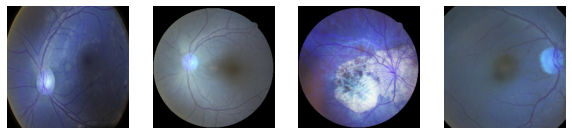

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [ ]:
xtrain, xtest, ytrain, ytest =  train_test_split(X, Y, test_size=.20, random_state=42)


In [ ]:
np.unique(Y)

array([0, 1, 2, 3])

In [ ]:
le = preprocessing.LabelEncoder()
ytrain = le.fit_transform(ytrain)
ytest = le.fit_transform(ytest)
ytrain = tf.keras.utils.to_categorical(ytrain, num_classes=4)
ytest = tf.keras.utils.to_categorical(ytest, num_classes=4)
ytrain = np.array(ytrain)
xtrain = np.array(xtrain)
ytest = np.array(ytest)
xtest = np.array(xtest)
print("X_train Shape: ", xtrain.shape)
print("X_test Shape: ", xtest.shape)
print("y_train Shape: ", ytrain.shape)
print("y_test Shape: ", ytest.shape)

X_train Shape:  (16400, 224, 224, 3)
X_test Shape:  (4100, 224, 224, 3)
y_train Shape:  (16400, 4)
y_test Shape:  (4100, 4)


In [ ]:
import pandas as pd
pd.Series(Y).value_counts()

0    6408
2    5221
1    5201
3    3670
dtype: int64

In [ ]:
from keras.applications import ResNet50


img_rows, img_cols = 224, 224


resnet = ResNet50(weights = 'imagenet',
                 include_top = False,
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in resnet.layers:
    layer.trainable = False

for (i,layer) in enumerate(resnet.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)


94765736/94765736 [==============================] - 3s 0us/step
0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 Activation False
5 ZeroPadding2D False
6 MaxPooling2D False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 Conv2D False
11 BatchNormalization False
12 Activation False
13 Conv2D False
14 Conv2D False
15 BatchNormalization False
16 BatchNormalization False
17 Add False
18 Activation False
19 Conv2D False
20 BatchNormalization False
21 Activation False
22 Conv2D False
23 BatchNormalization False
24 Activation False
25 Conv2D False
26 BatchNormalization False
27 Add False
28 Activation False
29 Conv2D False
30 BatchNormalization False
31 Activation False
32 Conv2D False
33 BatchNormalization False
34 Activation False
35 Conv2D False
36 BatchNormalization False
37 Add False
38 Activation False
39 Conv2D False
40 BatchNormalization False
41 Activation False
42 Conv2D False
43 BatchNormalization False
44 Activation False
45 Con

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import regularizers

def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(128,activation='relu')(top_model)
    top_model = Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.001))(top_model)
    top_model = Dropout(0.8)(top_model)
    top_model = Dense(4,activation='softmax')(top_model)
    return top_model

In [ ]:
from keras.models import Model


num_classes = 4

FR_Head = lw(resnet, num_classes)

model2 = Model(inputs = resnet.input, outputs = FR_Head)

print(model2.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
from keras.optimizers import SGD

model2.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_filepath = '/content/drive/MyDrive/ResNet50/Model-{epoch:02d}={val_accuracy:.4f}.hdf5'
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model2.fit(xtrain,ytrain,
                    epochs=270,callbacks=[checkpoint],
                    validation_data=(xtest,ytest),
                    verbose = 1,
                    initial_epoch=0, shuffle = True)

Epoch 1/270
513/513 [==============================] - ETA: 0s - loss: 1.5686 - accuracy: 0.2927
Epoch 1: val_accuracy improved from -inf to 0.34683, saving model to /content/drive/MyDrive/ResNet50/Model-01=0.3468.hdf5
513/513 [==============================] - 75s 125ms/step - loss: 1.5686 - accuracy: 0.2927 - val_loss: 1.4572 - val_accuracy: 0.3468
Epoch 2/270
513/513 [==============================] - ETA: 0s - loss: 1.4819 - accuracy: 0.3188
Epoch 2: val_accuracy improved from 0.34683 to 0.36683, saving model to /content/drive/MyDrive/ResNet50/Model-02=0.3668.hdf5
513/513 [==============================] - 62s 121ms/step - loss: 1.4819 - accuracy: 0.3188 - val_loss: 1.4312 - val_accuracy: 0.3668
Epoch 3/270
513/513 [==============================] - ETA: 0s - loss: 1.4592 - accuracy: 0.3415
Epoch 3: val_accuracy improved from 0.36683 to 0.38293, saving model to /content/drive/MyDrive/ResNet50/Model-03=0.3829.hdf5
513/513 [==============================] - 62s 122ms/step - loss: 1.4

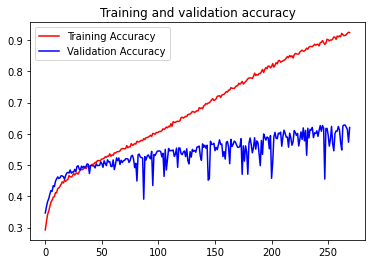

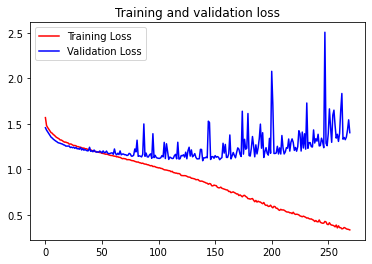

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
y_train_pred = model2.predict(xtrain)
y_test_pred = model2.predict(xtest)

129/129 [==============================] - 11s 86ms/step


In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
y_pred=model2.predict(xtest)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(ytest, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

print('Classification Report')
target_names = ['grade_0', 'grade_1', 'grade_2', 'grade_3']
print(classification_report(y_test, y_pred,))


129/129 [==============================] - 11s 86ms/step
[[747 226 244  60]
 [189 530 293  27]
 [122 107 734 114]
 [ 29   9 137 532]]
Classification Report
              precision    recall  f1-score   support

     grade_0       0.69      0.58      0.63      1277
     grade_1       0.61      0.51      0.55      1039
     grade_2       0.52      0.68      0.59      1077
     grade_3       0.73      0.75      0.74       707

    accuracy                           0.62      4100
   macro avg       0.64      0.63      0.63      4100
weighted avg       0.63      0.62      0.62      4100



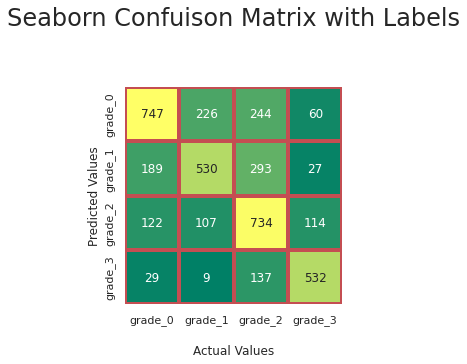

In [ ]:
import seaborn as sns
sns.set(font_scale=1.0)
ax=sns.heatmap(cm, annot=True, cmap='summer', cbar=False, linewidths=3, linecolor='r', square=True, xticklabels=target_names, yticklabels=target_names, fmt='')
sns.set(font_scale = 2.0)
ax.set_title('Seaborn Confuison Matrix with Labels\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel('Predicted Values');